# Exercise 1 (10 points)
Show that the $\ell 1$ norm is a convex function (as all norms), yet it is not strictly convex. In contrast, show that the squared Euclidean norm is a strictly convex function.


# Exercise 2 (10 points)
Let the observations resulting from an experiment be xn, n = 1, 2, . . . , N. Assume that they are independent and that they originate from a Gaussian PDF with mean $\mu$ and standard deviation $\sigma$. Both, the mean and the variance, are unknown. Prove that the maximum likelihood (ML) estimates of these quantities are given by

# Exercise 3 (15 points)
For the regression model where the noise vector η = [η1, . . . , ηN ]⊤ comprises samples from zero mean Gaussian random variable, with covariance matrix Σn, show that the Fisher information matrix is given by
I(θ) = X⊤Σ−1X, n
where X is the input matrix.

# Exercise 4 (20 points)
Consider the regression problem described in one of our labs. Read the same audio file, then add white Gaussian noise at a 15 dB level and randomly “hit” 10% of the data samples with outliers (set the outlier values to 80% of the maximum value of the data samples).


Recall from Lab 6 of the kernal ridge regression

In [2]:
from sklearn.svm import SVR
from datetime import datetime
import numpy as np
import math
import soundfile as sf
import matplotlib.pyplot as plt
import sys
import os
path = "/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/06/BladeRunner.wav"

In [3]:
# This is a helping funvtion that contains different types of kernels
def kappa(x, y, kernel_type, kernel_params):
  value = None
  if kernel_type == 'gaus':
    sigma = kernel_params[0]
    N = len(x)
    norm = sum((x-y)**2)
    value = np.exp(-norm/(sigma**2))
  elif kernel_type == 'gaus_c':
    sigma = kernel_params[0]
    N = len(x)
    exponent = sum( (x-y.conj())**2 )
    # value = 2*(math.exp( -np.real(exponent)/(sigma**2) ))
    value = 2*np.real(np.exp(-exponent/(sigma**2)))
  elif kernel_type == 'linear':
    value = 0
    N = len(x)
    for i in range(0, N):
      value = value + x[i]*y[i].conj()
  elif kernel_type == 'poly':
    d = kernel_params[0]
    value = (1 + x*y.transpose())**d
    # value = ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose())* np.real(y*y.transpose()) ) ) )**d;
  elif kernel_type == 'poly_c':
    d = kernel_params[0]
    value = 2*np.real((1 + x*y.transpose())**d)
  # value = 2*np.real( ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose()) * np.real(y*y.transpose()) ) ) )**d )
  return value

In [4]:
def kernel_regression_l2_l2_unbiased(X, y, params, kernel_type, kernel_params):
  lmbda = params[0]
  # build kernel matrix
  [d, N] = X.shape
  # for n=1:N
  #   for m=1:N
  #     K(n,m) = kappa(X(:,n), X(:,m), kernel_type, kernel_params);
  #   end;
  # end;
  if kernel_type == 'gaus':
    par = kernel_params
    norms = np.zeros(shape=(N, N))
    for i in range(0, N):
      T = X - X[:, i] # bsxfun(@minus,X,X(:,i))
      norms[i, :] = np.sum(T**2, axis=0)
    K = np.exp(-norms/(par**2))
  elif kernel_type == 'gaus_c':
    par = kernel_params
    norms = np.zeros(shape=(N, N))
    for i in range(0, N):
      T = X - X[:, i].conj() # bsxfun(@minus,X,conj(X(:,i)))
      norms[i, :] = np.sum(T**2, axis=0)
    K = 2*np.real(np.exp(-norms/(par**2)))
  else:
    K = np.zeros(shape=(N, N))
    for i in range(0, N):
      for j in range(0, N):
        K[i, j] = kappa(X[:, i], X[:, j], kernel_type, kernel_params)

  I = np.eye(N)
  A = lmbda*I+K
  c = y
  
  # Solve A*x=c
  sol = np.linalg.solve(A, c)
  return sol

In [5]:
# -----------------------------------------------------------------
# Kernel Ridge Regression
# on an audio sequence corrupted by
# Gaussian noise and outliers
# You need a .wav file to run the experiment...
# Python3 required packages: numpy, soundfile, matplotlib
# -----------------------------------------------------------------
def kernelridge_11_19():
  np.random.seed(0)
  # --------------------------------------------------------------------
  # Reading wav file. x corresponds to time instances (is., x_i in [0,1])
  # fs is the sampling frequency
  # Replace the name "BladeRunner.wav" with the name of the file
  # you intend to use.
  # --------------------------------------------------------------------
  N = 100
  samples = 1000
  indices = range(0, samples,int(samples/N))
  start = 100000
  [data, fs] = sf.read(path)
  sound = np.array(data[start:(start+samples+1), :], dtype=np.float32)
  y = np.reshape(sound[indices, 0], newshape=(len(indices), 1))
  Ts = 1/fs # sampling period
  x = np.array(range(0, samples)).conj().transpose()*Ts # time instances of sampling
  x = x[indices]
  x = np.reshape(x, newshape=(x.shape[0], 1))
  #print(x)
  # -------------------------------------------------------
  # Add white Gaussian noise
  snr = 15 # dB
  y = py_awgn(y, snr)
  # add outliers
  O = 0.8*np.max(np.abs(y))
  percent = 0.1
  M = int(math.floor(percent*N))
  out_ind = np.random.choice(N, M, replace=False)
  outs = np.sign(np.random.randn(M, 1))*O
  y[out_ind] = y[out_ind] + outs
  M = len(y)
  # ----------Code for unbiased L2 Kernel Ridge Regression (KRR-L2)-----------
  C = 0.0001
  kernel_type = 'gaus'
  kernel_params = 0.004
  sol = kernel_regression_l2_l2_unbiased(x.conj().transpose(), y, [C], kernel_type, kernel_params)
  a0 = sol[0:N]
  # Generate regressor
  t = np.array([range(0, samples)]).conj().transpose()*Ts # Here we generate all 1000 points that will be used for prediction
  #t = np.array([range(0, samples+1)]).conj().transpose()*Ts
  M2 = len(t)
  print(M2)
  z0 = np.zeros(shape=(M2, 1))
  for k in range(0, M2):
    z0[k] = 0
    for l in range(0, N):
      z0[k] = z0[k] + a0[l]*kappa(x[l], t[k], kernel_type,[kernel_params])
  # ------------------end unbiased KRR-L2-------------------------------------
  # For unbiased KRR-L2
  plt.figure(1)
  # plot(x,y);
  plt.xlabel('time in sec')
  plt.ylabel('amplitude')
  plt.plot(t, z0, 'r', lw=1)
  plt.plot(x, y, '.', markeredgecolor=[0.3, 0.3, 0.3], markersize=5)
  title = 'unbiased KRR-L2 C= %s' % str(C)
  plt.title(title)
  plt.show()


1000


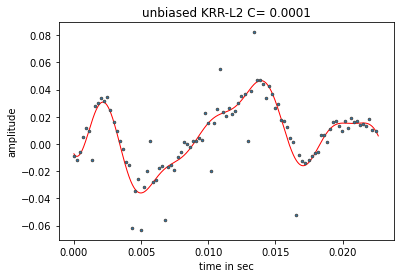

In [6]:
def py_awgn(input_signal, snr_dB, rate=1.0):
  """ Addditive White Gaussian Noise (AWGN) Channel.
  Parameters
  __________
  input_signal : 1D ndarray of floats
  Input signal to the channel.
  snr_dB : float
  Output SNR required in dB.
  rate : float
  Rate of the a FEC code used if any, otherwise 1.
  Returns
  _______
  output_signal : 1D ndarray of floats
  Output signal from the channel with the specified SNR.
  """
  avg_energy = np.sum(np.dot(input_signal.conj().T, input_signal)) / input_signal.shape[0]
  snr_linear = 10 ** (snr_dB / 10.0)
  noise_variance = avg_energy / (2 * rate * snr_linear)
  if input_signal.dtype is np.complex:
    noise = np.array([np.sqrt(noise_variance) * np.random.randn(input_signal.shape[0]) * (1 + 1j)], ndmin=2)
  else:
    noise = np.array([np.sqrt(2 * noise_variance) * np.random.randn(input_signal.shape[0])], ndmin=2)
  output_signal = input_signal + noise.conj().T
  return output_signal

if __name__ == '__main__':
  kernelridge_11_19()

Construct the support vector regression model

In [7]:
N = 100
samples = 1000
indices = range(0, samples,int(samples/N))
start = 100000
[data, fs] = sf.read(path)
sound = np.array(data[start:(start+samples+1), :], dtype=np.float32)
y = np.reshape(sound[indices, 0], newshape=(len(indices), 1))
Ts = 1/fs # sampling period
x = np.array(range(0, samples)).conj().transpose()*Ts # time instances of sampling
x = x[indices]
x = np.reshape(x, newshape=(x.shape[0], 1))
#print(x.shape)

#-------------------------------------------------------
# Add white Gaussian noise
snr = 15 # dB
y = py_awgn(y, snr)

# add outliers
O = 0.8*np.max(np.abs(y)) # set the outlier values to 80%
percent = 0.1
M = int(math.floor(percent*N))
out_ind = np.random.choice(N, M, replace=False)
outs = np.sign(np.random.randn(M, 1))*O
y[out_ind] = y[out_ind] + outs
y = y.ravel()
M = len(y)
# print(M)
#print(x.shape)
#print(y.shape)
#-------------------------------------------------------
# support vector regression
#C=1
#epsilon=0.003
#kernel_type='gaus'
#kernel_params=0.004

#-------------------------------------------------------

def svm_regression(Gau_kernal, epsilon, C):
  # fir regression model
  # coef0 - float, default=0.0: Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
  # C - float, default=1.0: Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.
  # epsilon - float, default=0.1 Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
  svr_rbf = SVR(kernel='rbf', C=C, coef0 = Gau_kernal, epsilon = epsilon)
  svr_lin = SVR(kernel='linear', C=C, coef0=Gau_kernal, epsilon = epsilon)
  svr_poly = SVR(kernel='poly', C=C, coef0=Gau_kernal, epsilon = epsilon, degree=2)
  y_rbf = svr_rbf.fit(x, y).predict(x)
  y_lin = svr_lin.fit(x, y).predict(x)
  y_poly = svr_poly.fit(x, y).predict(x)

  ###############################################################################
  # look at the results
  plt.scatter(x, y, c='k', label='data')
  #plt.hold('on')
  plt.plot(x, y_rbf, c='g', label='RBF model')
  plt.plot(x, y_lin, c='r', label='Linear model')
  plt.plot(x, y_poly, c='b', label='Polynomial model')
  plt.xlabel('data')
  plt.ylabel('target')
  plt.title('Support Vector Regression')
  plt.legend()
  plt.show()


(a) Find the reconstructed data samples obtained by the support vector regression. Employ the Gaussian kernel with σ = 0.004 and set ε = 0.003 and C = 1. Plot the fitted curve of the reconstructed samples together with the data used for training.

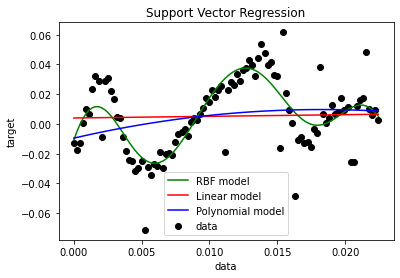

In [8]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 1)

(b) Repeat step (a) using C = 0.05, 0.1, 0.5, 5, 10, 100.


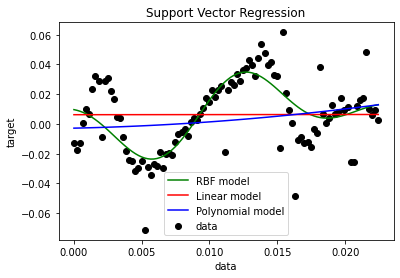

In [9]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 0.05)

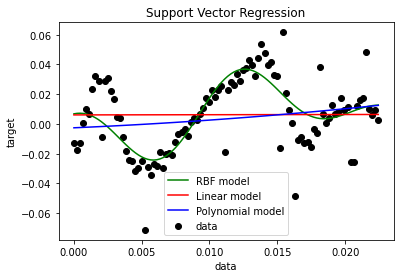

In [10]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 0.1)

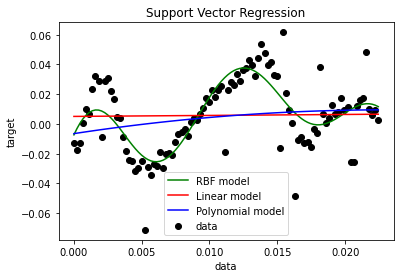

In [11]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 0.5)

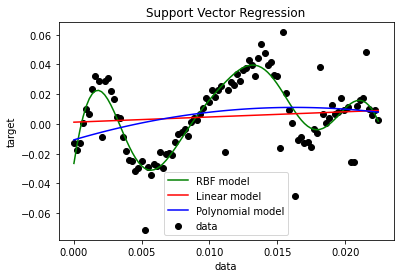

In [12]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 5)

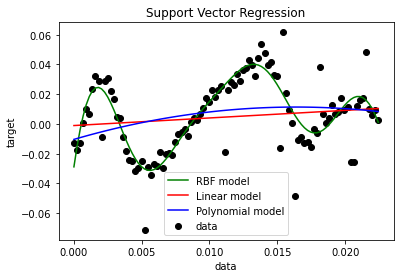

In [13]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 10)

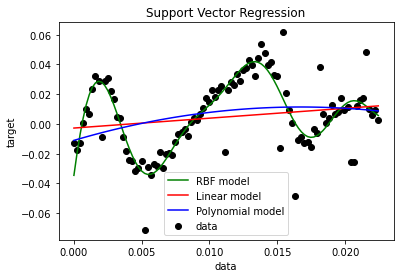

In [14]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.003, C = 100)

(c) Repeat step (a) using $\epsilon$ = 0.0005, 0.001, 0.01, 0.05, 0.1.


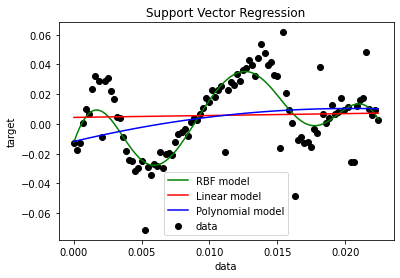

In [15]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.0005, C = 1)

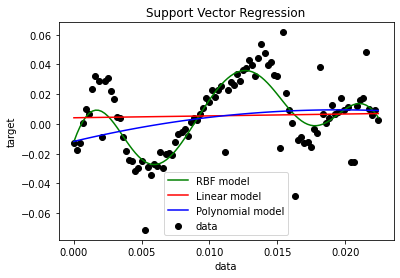

In [16]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.001, C = 1)

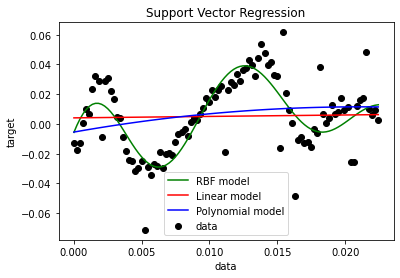

In [17]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.01, C = 1)

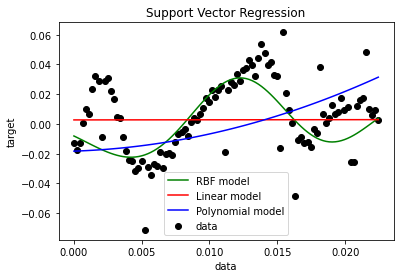

In [18]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.05, C = 1)

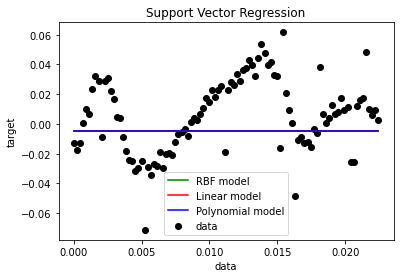

In [19]:
svm_regression(Gau_kernal = 0.004, epsilon = 0.1, C = 1)

(d) Repeat step (a) using $\sigma$ = 0.001, 0.002, 0.01, 0.05, 0.1.


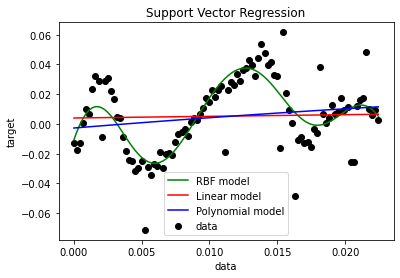

In [20]:
svm_regression(Gau_kernal = 0.001, epsilon = 0.003, C = 1)

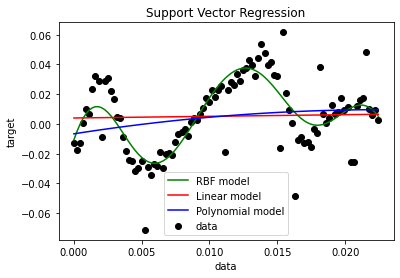

In [21]:
svm_regression(Gau_kernal = 0.002, epsilon = 0.003, C = 1)

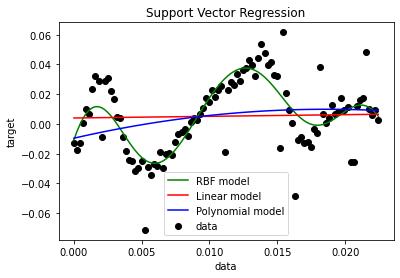

In [22]:
svm_regression(Gau_kernal = 0.01, epsilon = 0.003, C = 1)

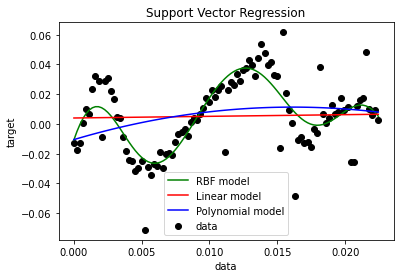

In [23]:
svm_regression(Gau_kernal = 0.05, epsilon = 0.003, C = 1)

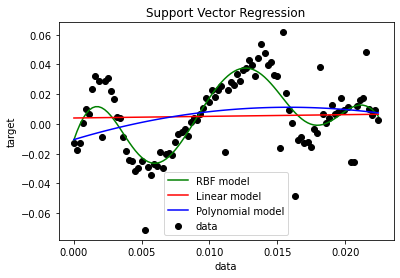

In [24]:
svm_regression(Gau_kernal = 0.1, epsilon = 0.003, C = 1)

(e) Comment on the results.

# Exercise 5 (15 points)
Show, using Lagrange multipliers, that the $\ell_2$ minimizer in equation (9.18) from the textbook accepts the closed form solution
$$
\hat{\theta} = X^T(XX^T)^{−1}y
$$
Now, show that for the system $y = X\theta$ with $X \in R^{n×l}$ and $n > l$ the least squares solution is given by
$$
\hat{\theta} = (X^TX)^{−1}X^Ty
$$



# Exercise 6 (10 points)
Show that the null space of a full rank $N × l$ matrix $X$ is a subspace of imensionality $l − N$ , for $N < l$.

# Exercise 7

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

N = 30 # 30 rows
k = 5 # first five components taking random values drawn from a normal distribution with mean zero and variance one and the rest being equal to zero
l = 100 # 100 columns

theta = np.zeros((l, 1))
theta[0:k] = np.random.standard_normal(size = (k, 1)) # draw samples from a standard Normal distribution (mean=0, stdev=1)
# print(theta)
X = np.dot(np.random.standard_normal(size = (N, l)),(1/math.sqrt(N)))
y = np.dot(X, theta)
print("X size is {}".format(X.shape))
print("y size is {}".format(y.shape))
#print(theta)

X size is (30, 100)
y size is (30, 1)


## 7a
Lasso regression performs L1 regularization, which adds a penalty equal to the absolute value of the magnitude of coefficients. This type of regularization can result in sparse models with few coefficients; Some coefficients can become zero and eliminated from the model. Larger penalties result in coefficient values closer to zero, which is the ideal for producing simpler models.

L1 tends to shink coefficients to zero. As we can see below, the cofficients are almost zero.

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

lasso_reconst = Lasso(fit_intercept=True, normalize=True, alpha = 0.1)
lasso_reconst.fit(X, y)
error_lasso = np.linalg.norm(theta - lasso_reconst.coef_)
print(lasso_reconst.coef_, lasso_reconst.intercept_)
print(error_lasso)

[-0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0.  0. -0.  0.  0.
 -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.
  0.  0.  0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0.  0. -0.  0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0. -0.  0.  0.
  0.  0. -0.  0. -0.  0. -0.  0. -0.  0.] [-0.03537962]
26.91810671110418


When we compare the coefficients in the linear model, they are non-zero.

In [27]:
linear_reconst = LinearRegression()
linear_reconst.fit(X, y)
error_lin = np.linalg.norm(theta - linear_reconst.coef_)
print(linear_reconst.coef_, linear_reconst.intercept_)
print(error_lin)

[[-0.16699232 -0.45806908 -0.35019419  0.15200234 -0.29730138 -0.09975496
   0.04209995  0.14447734  0.09847647 -0.11522187 -0.0572871  -0.08892935
   0.05851593 -0.06045867  0.02308987 -0.05732004  0.1012596   0.11117394
  -0.10993799  0.03713855  0.22065982 -0.09815186 -0.00769932 -0.05310192
  -0.01689664  0.06134959  0.02159899 -0.22876763 -0.14630284  0.06650093
  -0.14927092  0.08637465  0.07604179  0.19716973  0.08839756 -0.17278146
   0.19137566 -0.00973026  0.17533669 -0.27852196 -0.04380201 -0.12363319
  -0.14076449  0.08700037 -0.05914936 -0.32886476  0.09182957 -0.12840294
  -0.17806998 -0.00908293 -0.10458084  0.21395265  0.15274007  0.32816586
   0.01323328  0.03699134 -0.02795671  0.11067995  0.13024994 -0.02180561
  -0.15191039  0.08301984 -0.08478494  0.10957675 -0.0936104   0.0201665
   0.01899059  0.01877888 -0.02079505 -0.01105353 -0.04268249 -0.07296997
  -0.09687123 -0.13758942 -0.13082903  0.05856543  0.00930753  0.10064916
  -0.09436612  0.07016516  0.02961996 -

## 7b

The probability is 0 if we computer $||y = X\theta|| < 10^{-8}$ with the experiment 500 times.


In [28]:
rep = 500 # repeat the experiment 500 times
error = np.zeros((rep, 1))
print(error.shape)

for i in range(rep):
  X = np.dot(np.random.standard_normal(size = (N, l)),(1/math.sqrt(N))) # random values
  y = np.dot(X, theta)
  solved = Lasso().fit(X, y)
  errorX = np.linalg.norm(solved.coef_ - theta)
  #print(errorX)
  error[i] = errorX < 10**-8# yes return 1, otherwise 0

prob = sum(error)/rep
print("The probility is {}".format(prob))

(500, 1)
The probility is [0.]


## 7c

In [ ]:
p = [1, 9, 25, 36, 64]
error = np.zeros((rep, 1))
X = []

# construct sparse sensing matrices
OK = False
for pval in p:
  for i in range(rep):
    while not OK:
      kk = np.zeros((N*l, 1))
      P = np.random.permutation(N*l)
      numofzeros = round(N*l*(1-1/math.sqrt(pval)))
      P[N*l-numofzeros:] = np.array([])
      kk[P] = np.multiply(np.dot(math.sqrt((math.sqrt(pval)/N)), np.ones((len(P),1))) , np.sign(np.random.rand(len(P),1)))
      X = np.zeros((N, l))
      X[:l*N] = kk
      OK = np.linalg.matrix_rank(X) == N # Return matrix rank of array using SVD method, also check if there is a full rank
      break
    y = np.dot(X, theta)
    L1_model = Lasso().fit(X, y)
    errorX = np.linalg.norm(L1_model.coef_-theta)
    error[i] = errorX<10**-8 + 0 # yes return 0, otherwise 1

  prob = sum(error)/rep
  print("The probility is {}".format(prob))


# Testing Zone

In [29]:
P = np.random.permutation(N*l)
print(P.shape)

(3000,)


# References:
- https://www.statisticshowto.com/lasso-regression/ 
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
